In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt

import aux_func_nopyfvcom as af
import tidal_filter as tf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22, 'figure.figsize':(16, 16)})


In /home/rito/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rito/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rito/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rito/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rito/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_c

# Defining cross sections
We define the cross sections on the domain to work with To define the cross sections we used the function xxx, see the ancillary notebook yyy. 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: tamar_v2 FVCOM ver4.0 with Nesting, wind
    institution: School for Marine Science and Technology
    source: FVCOM_3.0
    history: Tue May  3 12:44:06 2022: ncks -d time,-2,-1 tamar_v2_0001.nc tamar_v2_2tsteps.nc
model started at: 08/04/2022   01:47
    references: http://fvcom.smast.umassd.edu, http://codfish.smast.umassd.edu
    Conventions: CF-1.0
    CoordinateSystem: Cartesian
    CoordinateProjection: proj=utm +ellps=WGS84 +zone=30
    Tidal_Forcing: TIDAL ELEVATION FORCING IS OFF!
    River_Forcing: THERE ARE 10 RIVERS IN THIS MODEL.
RIVER INFLOW IS ON THE nodes WHERE TEMPERATURE AND SALINITY ARE calculated IN THE MODEL.
THE FOLLOWING RIVER NAMES ARE USED:
river_-3.883872_50.281806
river_-4.019318_50.341443
river_-4.386943_50.364077
river_-4.303740_50.403514
river_-3.947841_50.308737
river_-4.641431_50.329483
river_-4.205975_50.519058
river_-4.279699_50.405888
river_-4.156

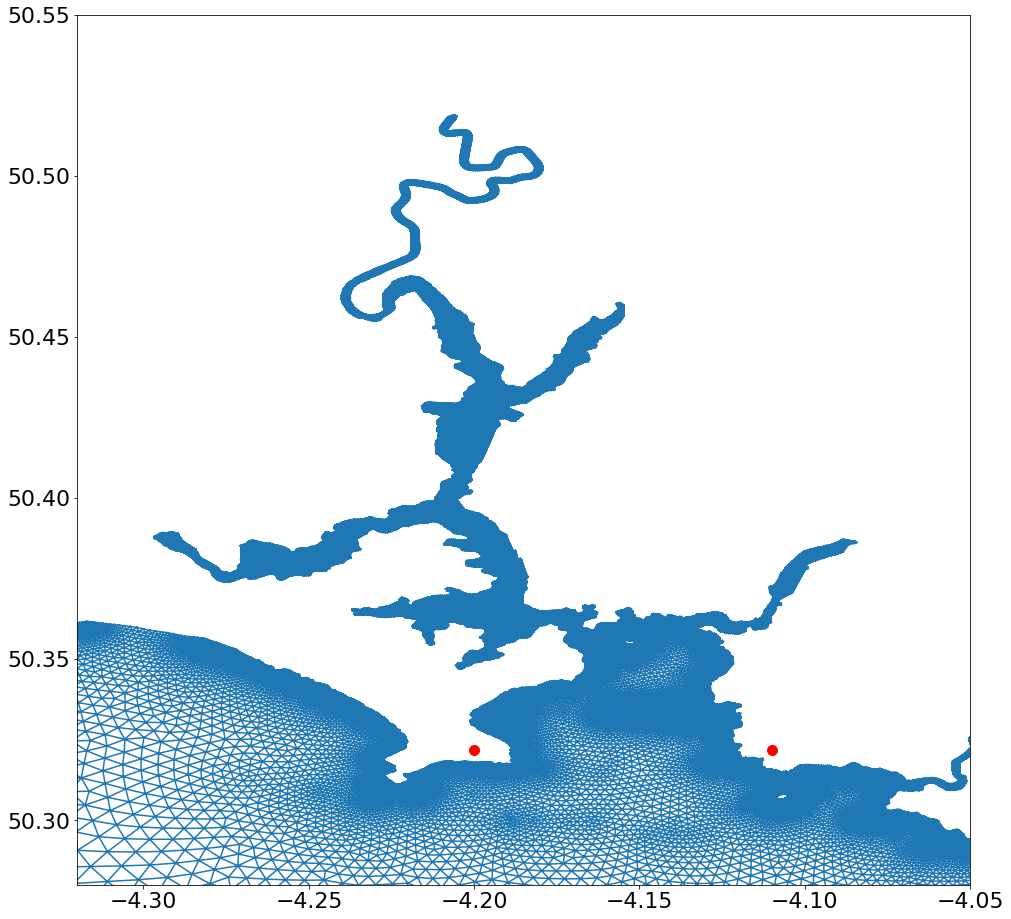

In [7]:
# Load an output file to get the grid variables
thredds_source = 'https://data.ecosystem-modelling.pml.ac.uk/thredds/dodsC/mycoast-all-files/Model/IMMERSE_data'
thredds_fvcom_output = f'{thredds_source}/tamar_v2_2tsteps.nc'
tamar_nc = nc.Dataset(thredds_fvcom_output)

#print (tamar_nc)

node_ll = np.asarray([tamar_nc.variables['lon'][:], tamar_nc.variables['lat'][:]]).T
ele_ll = np.asarray([tamar_nc.variables['lonc'][:], tamar_nc.variables['latc'][:]]).T
grid_triangles = tamar_nc.variables['nv'][:].T - 1

chosen_pts = np.asarray([(-4.2, 50.322), (-4.11, 50.322)])


# Plot the cross sections
plt_lims = [[-4.32, -4.05], [50.28, 50.55]]

plt.triplot(node_ll[:,0], node_ll[:,1], grid_triangles)
plt.xlim(plt_lims[0])
plt.ylim(plt_lims[1])
plt.scatter(chosen_pts[:,0], chosen_pts[:,1], s=100, c='r')



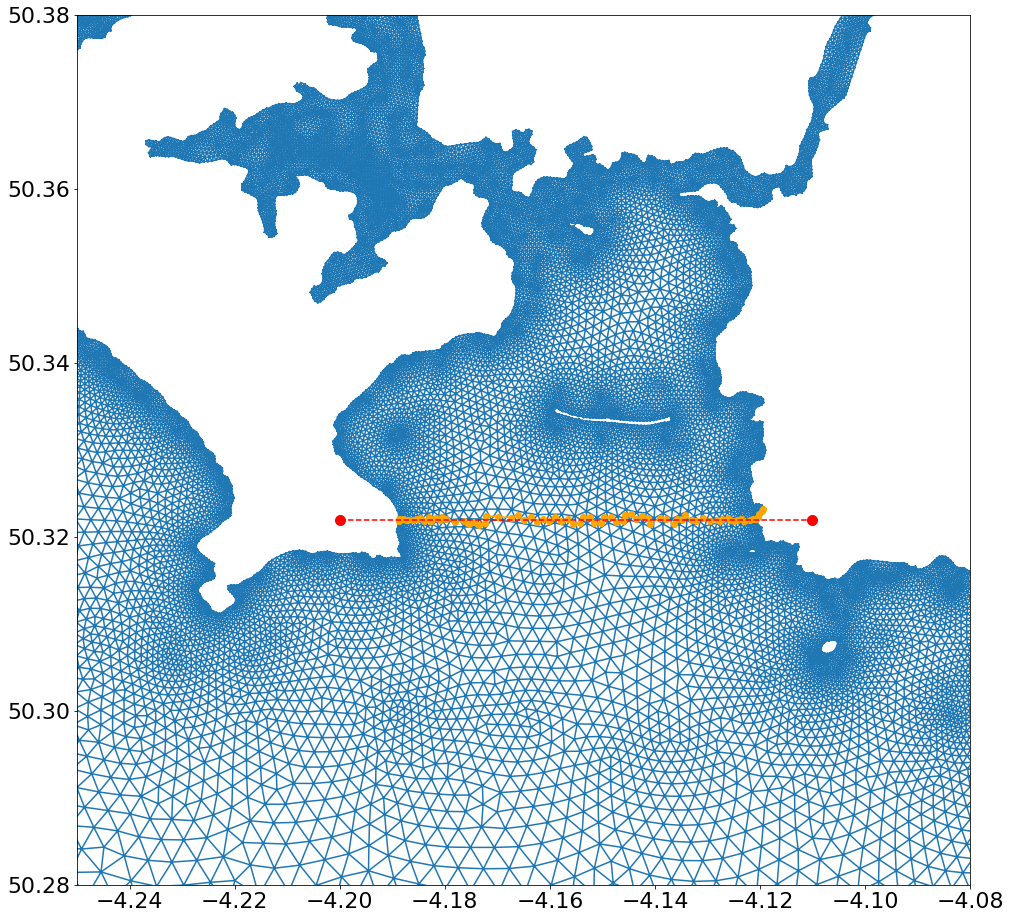

In [4]:
# Needs to be in utm
from pyproj import Proj
utm30 = Proj('EPSG:32630')
chosen_pts_utm = utm30(chosen_pts[:,0], chosen_pts[:,1])

cross_sect_pts = np.asarray(af.define_centroid_cross_section(np.asarray(chosen_pts_utm).T, tamar_nc))
# Plot the cross sections
plt_lims = [[-4.25, -4.08], [50.28, 50.38]]

plt.triplot(node_ll[:,0], node_ll[:,1], grid_triangles)
plt.xlim(plt_lims[0])
plt.ylim(plt_lims[1])
plt.scatter(np.asarray(chosen_pts)[:,0], np.asarray(chosen_pts)[:,1], s=100, c='r')
plt.plot(np.asarray(chosen_pts)[:,0], np.asarray(chosen_pts)[:,1],c='r', linestyle='--', zorder=3)
plt.scatter(ele_ll[cross_sect_pts,0], ele_ll[cross_sect_pts,1], c='orange', zorder=2)
plt.plot(ele_ll[cross_sect_pts,0], ele_ll[cross_sect_pts,1], c='orange')



In [8]:
# Now get the data, salinity and ssh have to be interpolated to the same place as the ve
cross_u = tamar_nc.variables['u'][:,:,cross_sect_pts]
cross_v = tamar_nc.variables['v'][:,:,cross_sect_pts]
cross_zeta = af.node_to_centre(tamar_nc.variables['zeta'][:], tamar_nc)[:,cross_sect_pts]

cross_sal_centre = []
for this_dep in np.arange(0, tamar_nc.variables['salinity'][:].shape[1]):
    print(f"Interpolating depth layer {this_dep + 1} of {tamar_nc.variables['salinity'][:].shape[1]}")
    cross_sal_centre.append(af.node_to_centre(np.squeeze(tamar_nc.variables['salinity'][:,this_dep,:]), tamar_nc))
cross_sal = np.asarray(cross_sal_centre)[:,:,cross_sect_pts]
cross_sal = np.moveaxis(cross_sal, 1,0)

date_str = np.asarray([b''.join(this_str).decode('utf-8') for this_str in tamar_nc.variables['Times'][:]])
date_list = [dt.datetime.strptime(this_str, '%Y-%m-%dT%H:%M:%S.000000') for this_str in date_str]



RuntimeError: NetCDF: Access failure

# Defining cross sections
We have already extracted the velocity, sea surface height (zeta), and salinity for all the points along the cross sections from a seven month long time series. In the case of the salinity we have interpolated it from the node points of the grid to the element centres so that it is now co-located with the velocities. 

In the next section we calculate the fluxes across these cross sections. The first step is to calculate the (time-varying) mesh of trapezes which form the cross section. These are then used to calculate the normal velocity which is multiplied by the trapeze areas to get the flux.

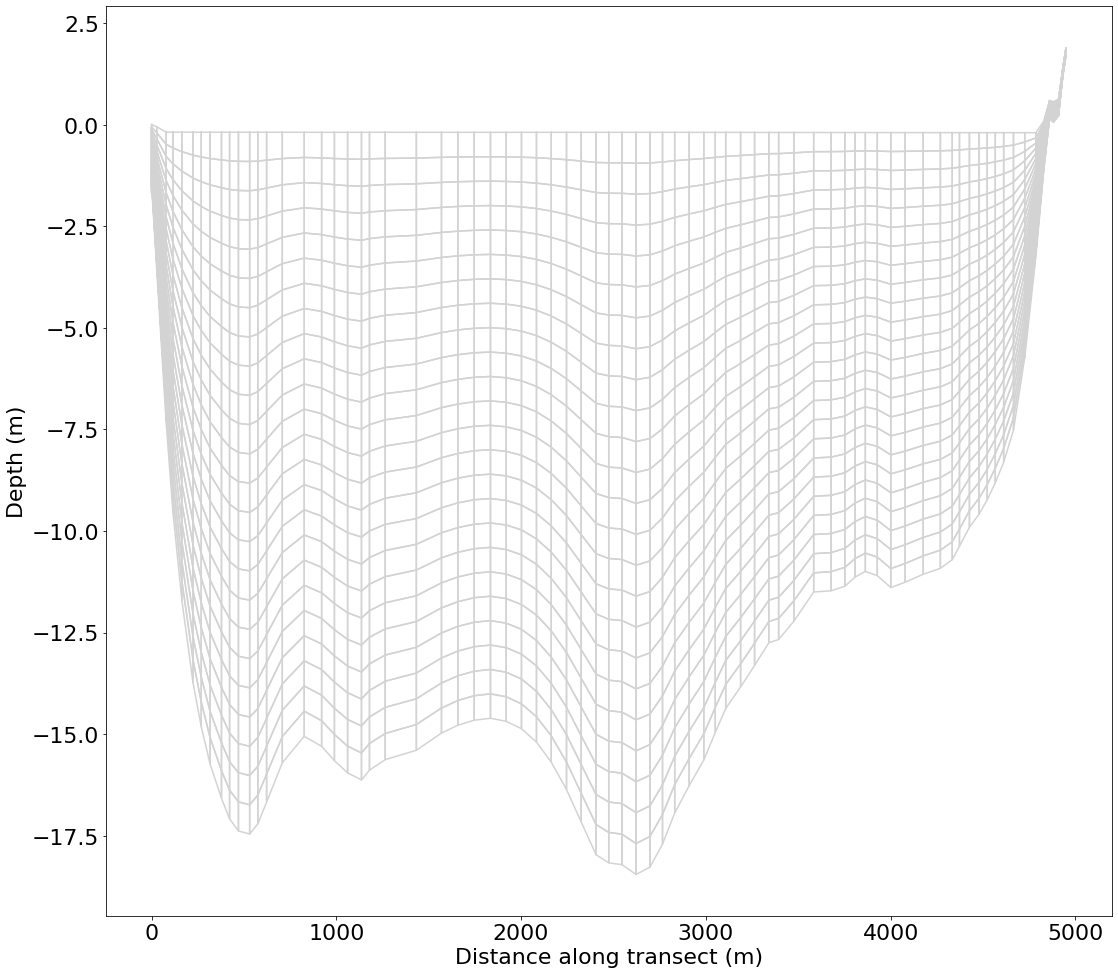

In [9]:
# Load the pre extracted netcdf data
thredds_cross_section_data = f'{thredds_source}/cross_section_data.nc'
cross_section_nc = nc.Dataset(thredds_cross_section_data)

cross_u = cross_section_nc.variables['u'][:]
cross_v = cross_section_nc.variables['v'][:]
cross_sal = cross_section_nc.variables['sal'][:]
cross_zeta = cross_section_nc.variables['zeta'][:]

# calculate volume flux and bin by each salinity class
# salinity is interpolated to centroids using node_to_centre
# v
grid_information = {'xc':tamar_nc.variables['xc'][:], 'yc':tamar_nc.variables['yc'][:], 
                 'h_center':tamar_nc.variables['h_center'][:], 'siglev_center':tamar_nc.variables['siglev_center'][:],
                 'siglay_center':tamar_nc.variables['siglay_center'][:]}

cross_sqrs, cross_norms, cross_areas, cross_mids = af.cross_sect_trapeze(cross_sect_pts, cross_zeta, grid_information)

cross_areas = np.moveaxis(cross_areas, [2,1], [1,2])
cross_norms = np.moveaxis(cross_norms, [2,1], [1,2])

flux = cross_areas * (cross_norms[:,:,:,0]*cross_u + cross_norms[:,:,:,1]*cross_v)

# Add the plot of the mesh and norms
# Plot the Mesh and maybe the flux at one tstp
time_stp = 0

sqrs = cross_sqrs[time_stp]
all_plot_sqrs = af.get_plot_sqr(sqrs)

mid_z = cross_mids[2][time_stp,:,:]
mid_x = np.tile(cross_mids[0][np.newaxis,:], [mid_z.shape[0], 1])

min_x = np.min(all_plot_sqrs[0][0][0])
for this_row in np.arange(0, sqrs.shape[0]):
    for this_col in np.arange(0, sqrs.shape[1]):
        min_x = min(min_x, np.min(all_plot_sqrs[this_row][this_col][0]))

plt.figure(figsize=[16,14])
for this_row in np.arange(0, sqrs.shape[0]):
    for this_col in np.arange(0, sqrs.shape[1]):
        plt.plot(all_plot_sqrs[this_row][this_col][0] - min_x, all_plot_sqrs[this_row][this_col][1], c='lightgray')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Depth (m)')
plt.tight_layout()



# Calculating the flux in salinity classes

From this we then get the net flux for each salinity bin. Here we have chosen salinity increments of 0.2 psu but these can be adjusted to suite the salinity range of the cross section being studied.

The complete explanation can be found in cite Macready 2016.


In [10]:
# define salinity bins (1751 from 0 to 35, 0.2 increments)

sal_bins = np.linspace(0,36.2,1811)

bin_mids = []
for i in np.arange(1, len(sal_bins)):
    ds = sal_bins[i] - sal_bins[i-1]
    bin_mids.append(sal_bins[i-1] + ds/2)
bin_mids = np.asarray(bin_mids)

# calculate volume flux and bin by each salinity class
# salinity is interpolated to centroids using node_to_centre
# v

# the horizontal cross section (control area)  of each centroid area is trapezoidal
# define these in the depth varying grid
# integrate for sal > s 
all_dq_ds = []

perc_div = 0.05
perc = perc_div
for this_t in np.arange(0, len(flux)):
    if this_t/len(flux) > perc:
            print('{} % done'.format(np.round(perc*100)))
            perc+=perc_div
    dq_ds = []

    this_flux = flux[this_t, :, :]
    this_sal = cross_sal[this_t, :, :]

    for i in np.arange(1, len(sal_bins)):
            ds = sal_bins[i] - sal_bins[i-1]

            flux_i1 = np.sum(this_flux[this_sal > sal_bins[i-1]]) if np.any(this_sal > sal_bins[i-1]) else 0
            flux_i = np.sum(this_flux[this_sal > sal_bins[i]]) if np.any(this_sal > sal_bins[i]) else 0 

            dq_ds.append((flux_i1 - flux_i)/ds)
    all_dq_ds.append(np.asarray(dq_ds))

all_dq_ds = np.asarray(all_dq_ds)

# Set some parameters to filter by
cut_off = 72 # Omit the first day
N = 10  # 

#all_dq_ds = all_dq_ds[cut_off:,:]  # Comment out for now till we have a longer file available

all_dq_ds_filt = []
for i in np.arange(0, len(bin_mids)):
        all_dq_ds_filt.append(tf.lowpass_godin(np.squeeze(all_dq_ds[:,i]), mean_dt_h=1))
all_dq_ds_filt = np.asarray(all_dq_ds_filt).T

all_dq_ds_filt_conv = []
for this_t in all_dq_ds_filt:
        all_dq_ds_filt_conv.append(np.convolve(this_t, np.ones(N)/N, mode='valid'))
all_dq_ds_filt_conv = np.asarray(all_dq_ds_filt_conv)
bin_mids_conv = bin_mids[int(N/2):-int(N/2)+1]

this_t_q_out = []
this_t_q_in = []
this_f_out = []
this_f_in = []

for this_t in all_dq_ds_filt_conv:
        this_t_q_out.append(np.sum(this_t[this_t<0]))
        this_t_q_in.append(np.sum(this_t[this_t>0]))
        this_f_in.append(np.sum(this_t[this_t>0]*bin_mids_conv[this_t>0]))
        this_f_out.append(np.sum(this_t[this_t<0]*bin_mids_conv[this_t<0]))

q_out = np.asarray(this_t_q_out)
q_in = np.asarray(this_t_q_in)

f_out = np.asarray(this_f_in)
f_in = np.asarray(this_f_out)

s_in = np.asarray(this_f_in)/np.asarray(this_t_q_in)
s_out = np.asarray(this_f_out)/np.asarray(this_t_q_out)

5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done


Text(0.5, 0, 'Time (Day-Month HH)')

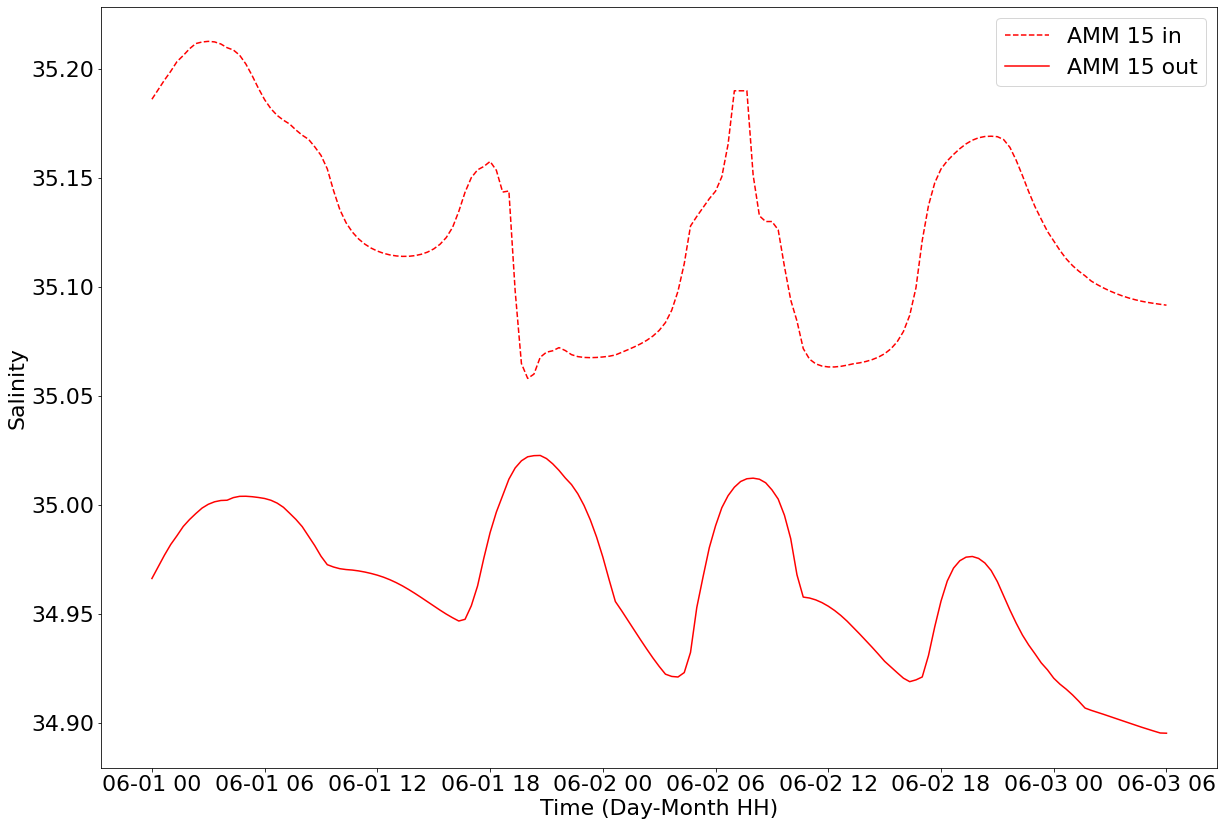

In [20]:
# To do Plot the output for these two days?
# Example of mean salinity in inflow and outflow at transect

date_str = np.asarray([b''.join(this_str).decode('utf-8') for this_str in cross_section_nc.variables['Times'][:]])
date_list = [dt.datetime.strptime(this_str, '%Y-%m-%dT%H:%M:%S.000000') for this_str in date_str]
plt.figure(figsize=[20,14])
plt.plot(date_list, s_in[:], c='r', linestyle='--')
plt.plot(date_list, s_out[:], c='r')
plt.legend(['AMM 15 in', 'AMM 15 out'])
plt.ylabel('Salinity')
plt.xlabel('Time (Day-Month HH)')


# Plotting the flux and mixing properties

To demonstrate the mixing properties we have precalculated the dq_ds for longer time series from two cross sections 

The cross sections chosen


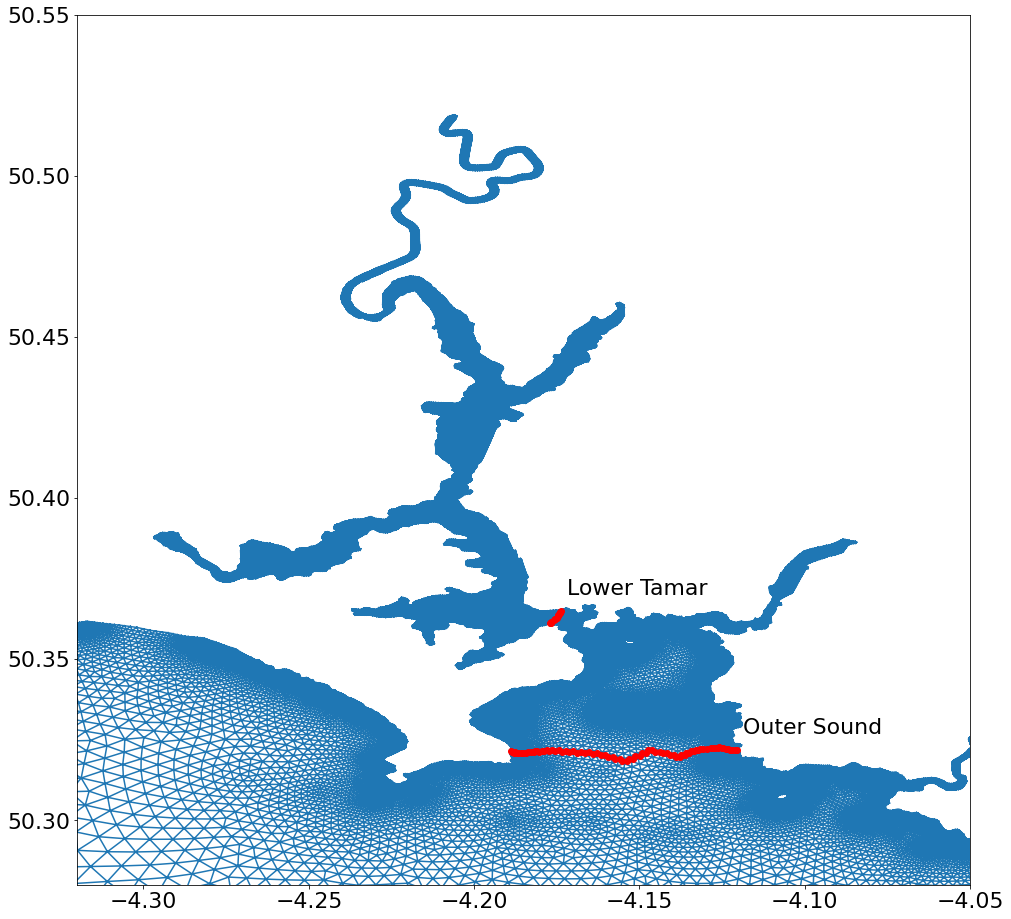

In [21]:
plot_titles = {'lower_tamar':'Lower Tamar', 'outer_sound': 'Outer Sound'}

cross_sects = np.load('cross_sect_defn.npy', allow_pickle=True).item()
print('The cross sections chosen')

# Plot the cross sections
plt_lims = [[-4.32, -4.05], [50.28, 50.55]]
name_adj = [0.0018, 0.005]

plt.triplot(node_ll[:,0], node_ll[:,1], grid_triangles)
plt.xlim(plt_lims[0])
plt.ylim(plt_lims[1])

for this_name, this_title in plot_titles.items():
    this_nodes = cross_sects[this_name]
    plt.scatter(ele_ll[:,0][this_nodes], ele_ll[:,1][this_nodes], c='r', zorder=2)
    plt.plot(ele_ll[:,0][this_nodes], ele_ll[:,1][this_nodes], c='r')
    plt.text(ele_ll[:,0][this_nodes[-1]] + name_adj[0], ele_ll[:,1][this_nodes[-1]] + name_adj[1],this_title)
plt.show()




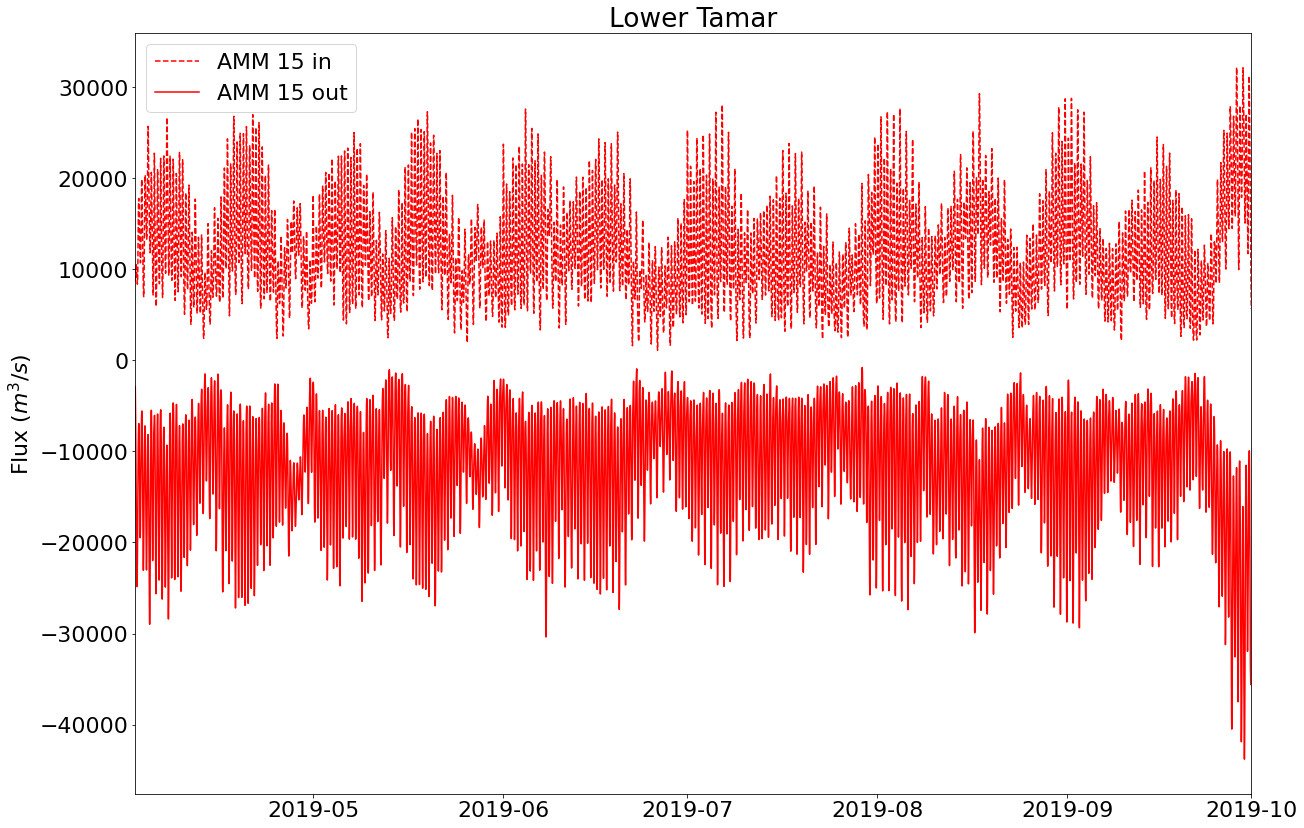

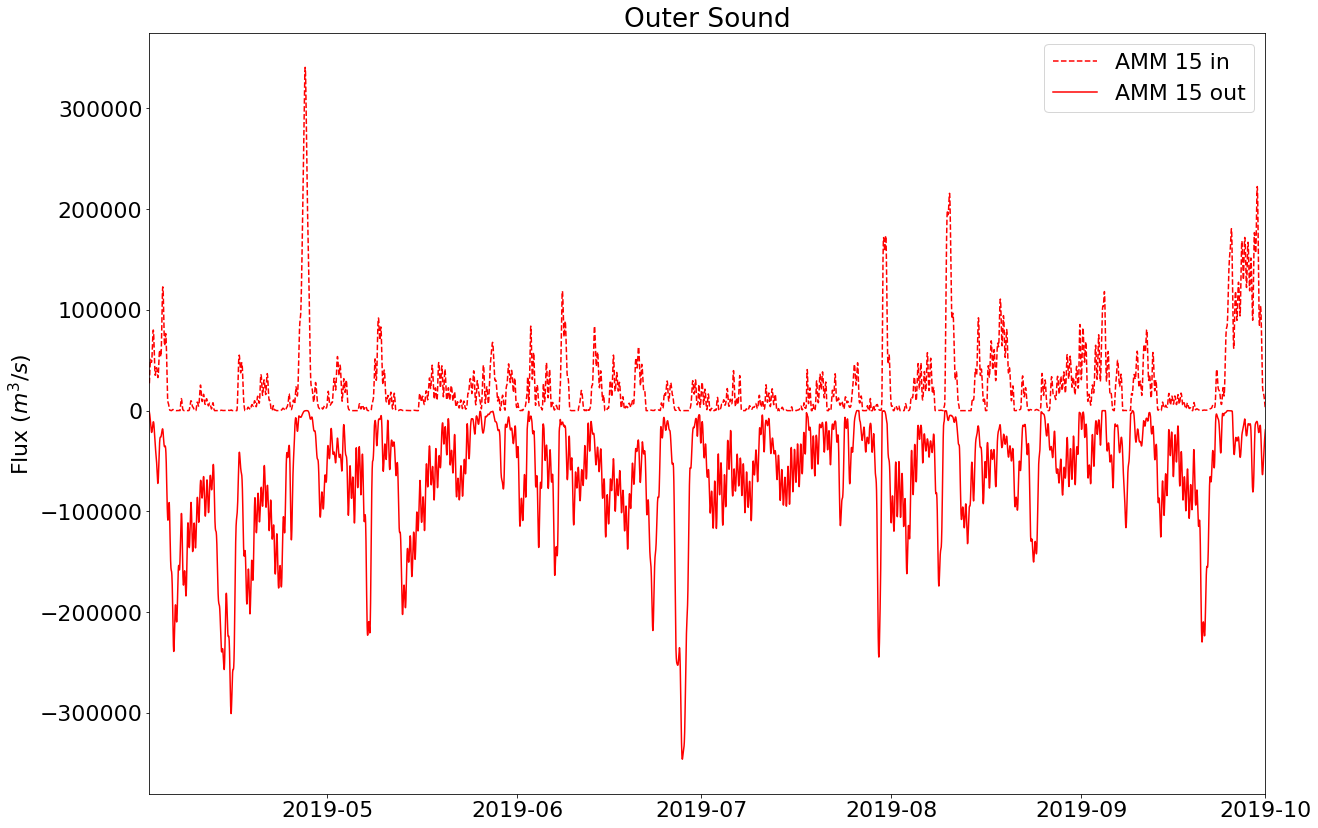

In [22]:
# Plot the subtidal flux in and out at each cross section
for cross_sect in plot_titles.keys():
    this_nc = nc.Dataset(f'{thredds_source}/{cross_sect}_dqds.nc')
    this_date_str = np.asarray([b''.join(this_str).decode('utf-8') for this_str in this_nc.variables['Times'][:]])
    this_dt = [dt.datetime.strptime(this_str, '%Y-%m-%dT%H:%M:%S.000000') for this_str in this_date_str]
    
    plt.figure(figsize=[20,14])
    plt.plot(this_dt, this_nc.variables['q_in'][:], c='r', linestyle='--')
    plt.plot(this_dt, this_nc.variables['q_out'][:], c='r')
    plt.xlim([np.min(this_dt), np.max(this_dt)])
    plt.legend(['AMM 15 in', 'AMM 15 out'])
    plt.ylabel('Flux ($m^3/s$)')
    plt.xlabel('Date (Year-Month)')
    plt.title(plot_titles[cross_sect])



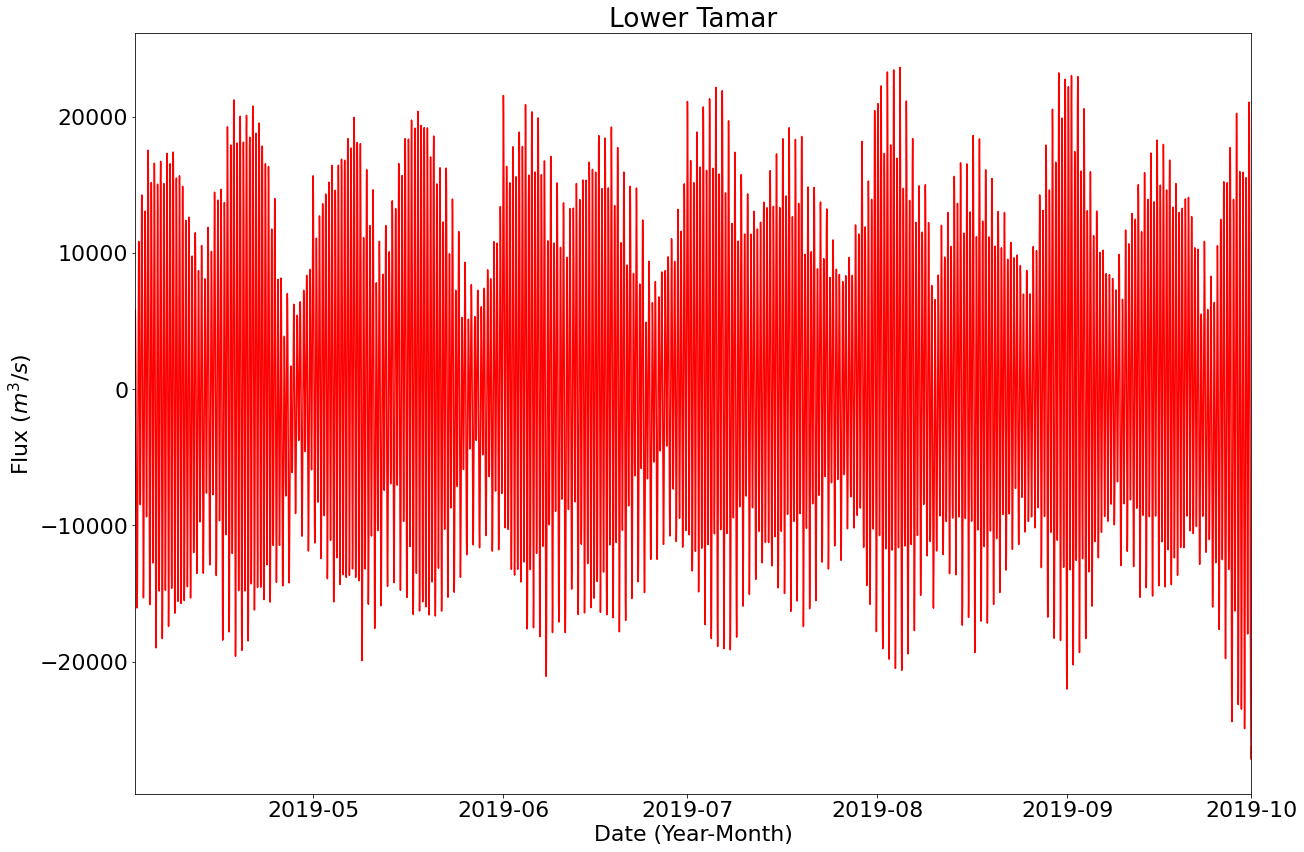

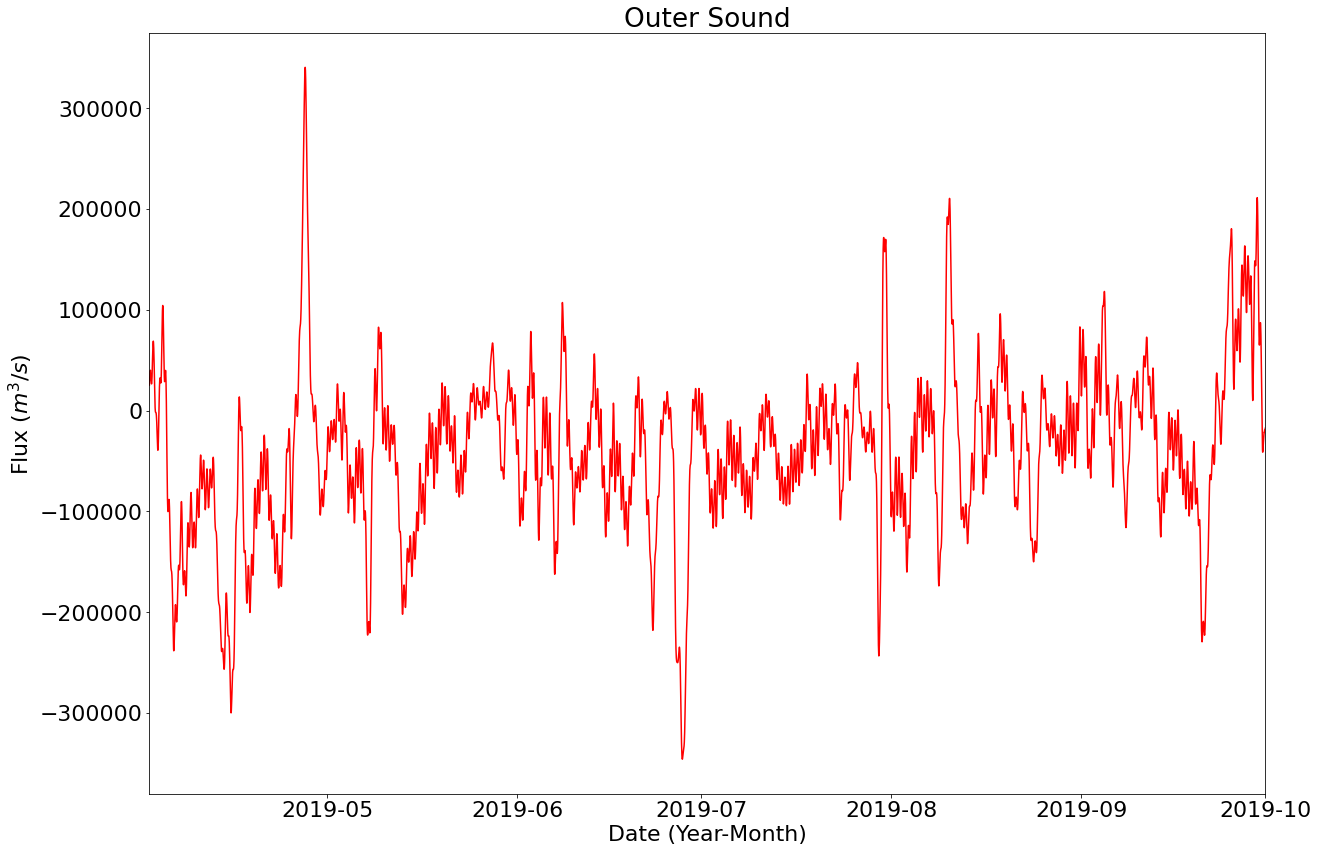

In [23]:
# Plot net flux
for cross_sect in plot_titles.keys():
    this_nc = nc.Dataset(f'{thredds_source}/{cross_sect}_dqds.nc')
    this_date_str = np.asarray([b''.join(this_str).decode('utf-8') for this_str in this_nc.variables['Times'][:]])
    this_dt = [dt.datetime.strptime(this_str, '%Y-%m-%dT%H:%M:%S.000000') for this_str in this_date_str]
 
    plt.figure(figsize=[20,14])
    plt.plot(this_dt, this_nc.variables['q_in'][:] +  this_nc.variables['q_out'][:], c='r')
    plt.xlim([np.min(this_dt), np.max(this_dt)])
    plt.ylabel('Flux ($m^3/s$)')
    plt.xlabel('Date (Year-Month)')
    plt.title(plot_titles[cross_sect])

We can use this to see the salinity classes which flow in and out at each cross section

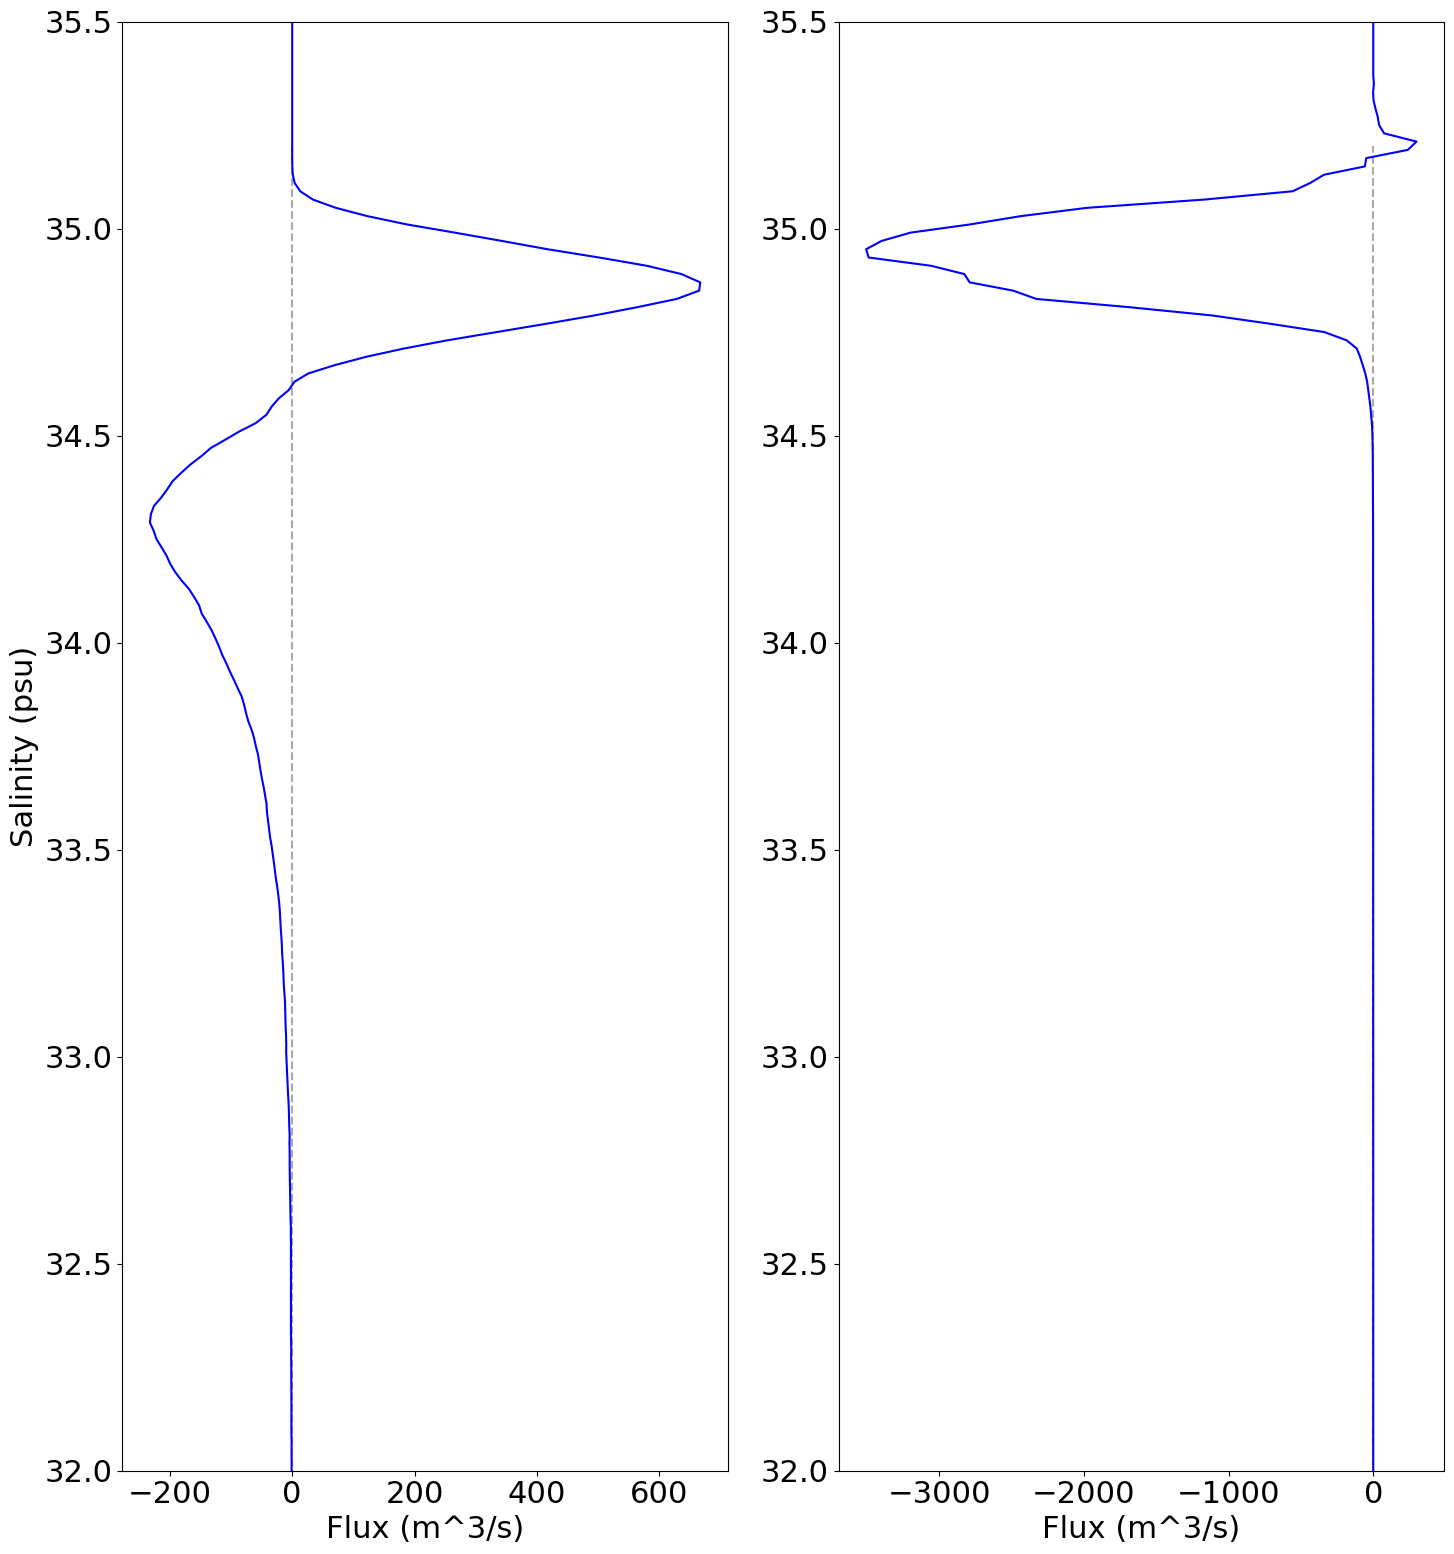

In [12]:
# Plot the average flux at each salinity 
low_sal = 32

fig, ax = plt.subplots(1,2, figsize=[15,16])
for i, cross_sect in enumerate(plot_titles.keys()):
    this_nc = nc.Dataset(f'{thredds_source}/{cross_sect}_dqds.nc')
    ax[i].plot([0,0],[28.5,35.2], c='darkgrey', linestyle='--')
    ax[i].plot(np.mean(this_nc.variables['dq_ds'][:], axis=0), this_nc.variables['bins_mid'][:], c='b')
    ax[i].set_xlabel('Flux ($m^3/s$)')
    if i ==0:
        ax[i].set_ylabel('Salinity (psu)')
    ax[i].set_ylim([low_sal,35.5])
plt.tight_layout()


There are many other quantities we can calcuate, for example mixing as defined in cite Macready2018 as 'the volume integrated destruction of internal salinity variance'


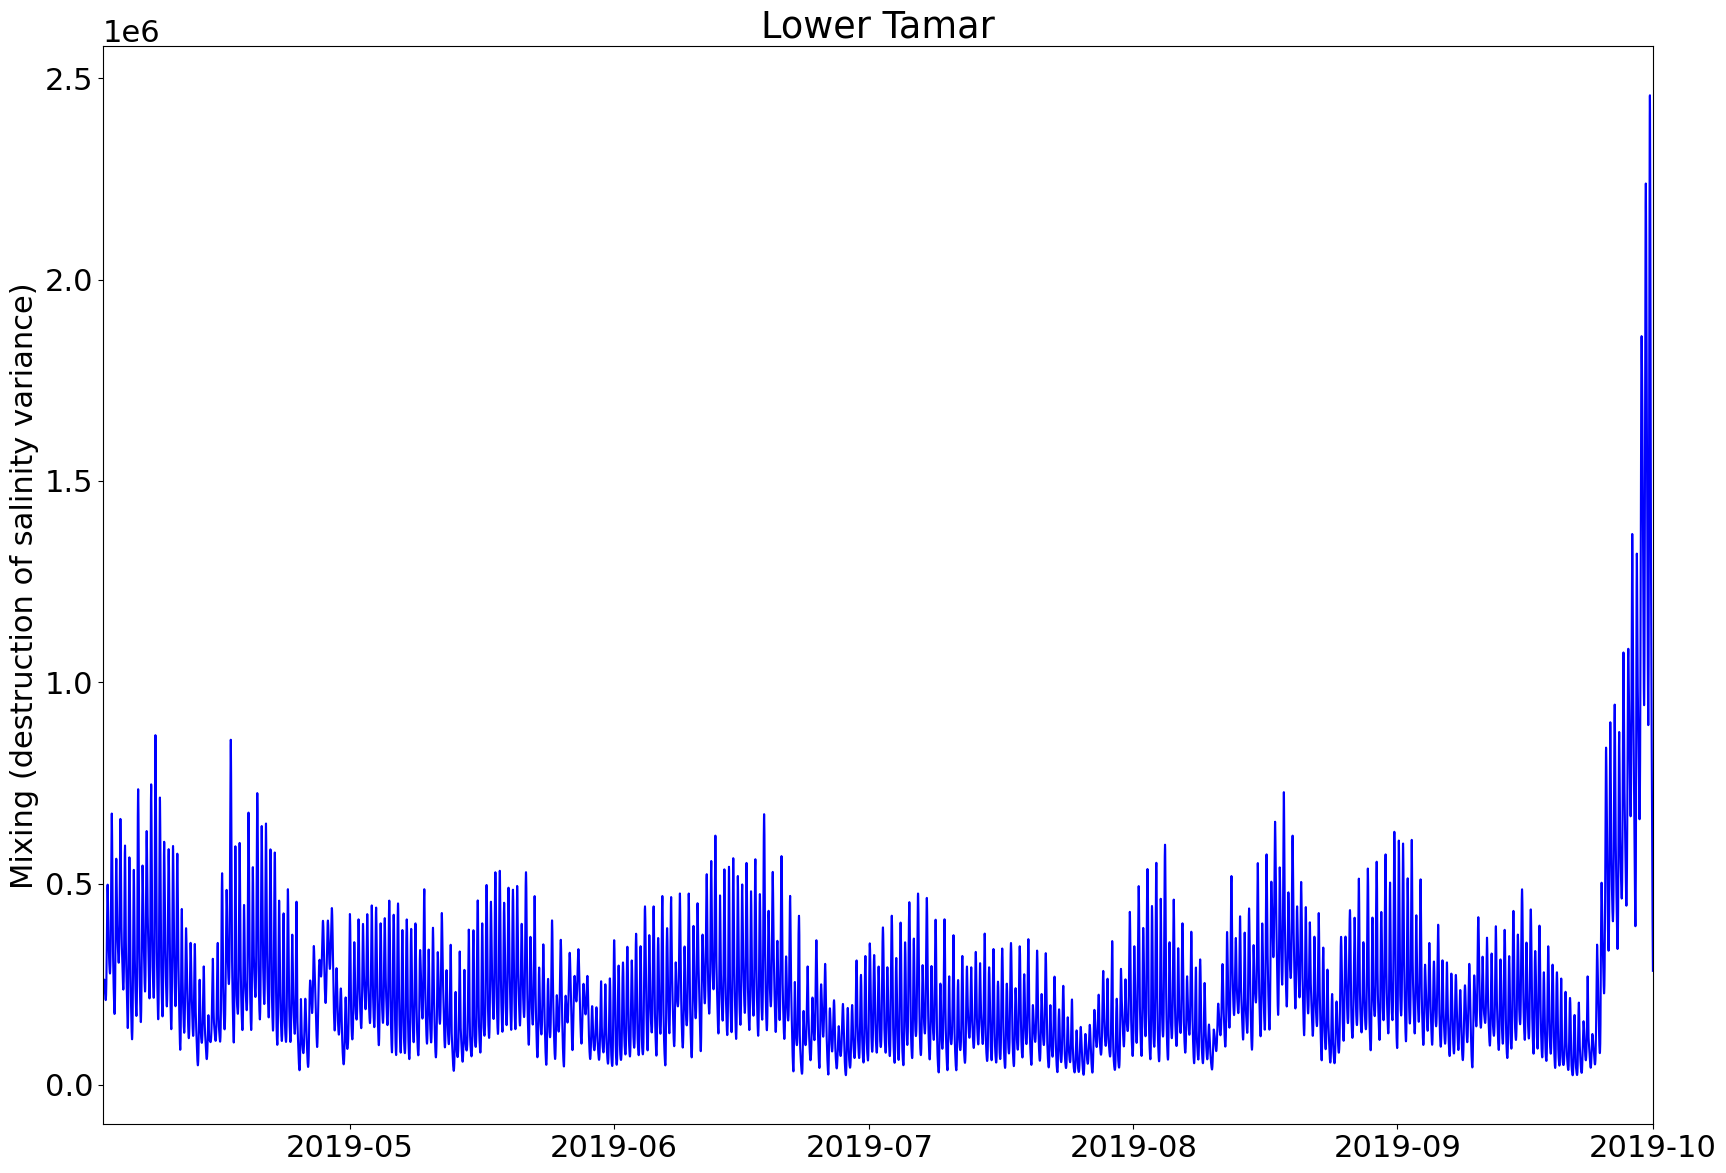

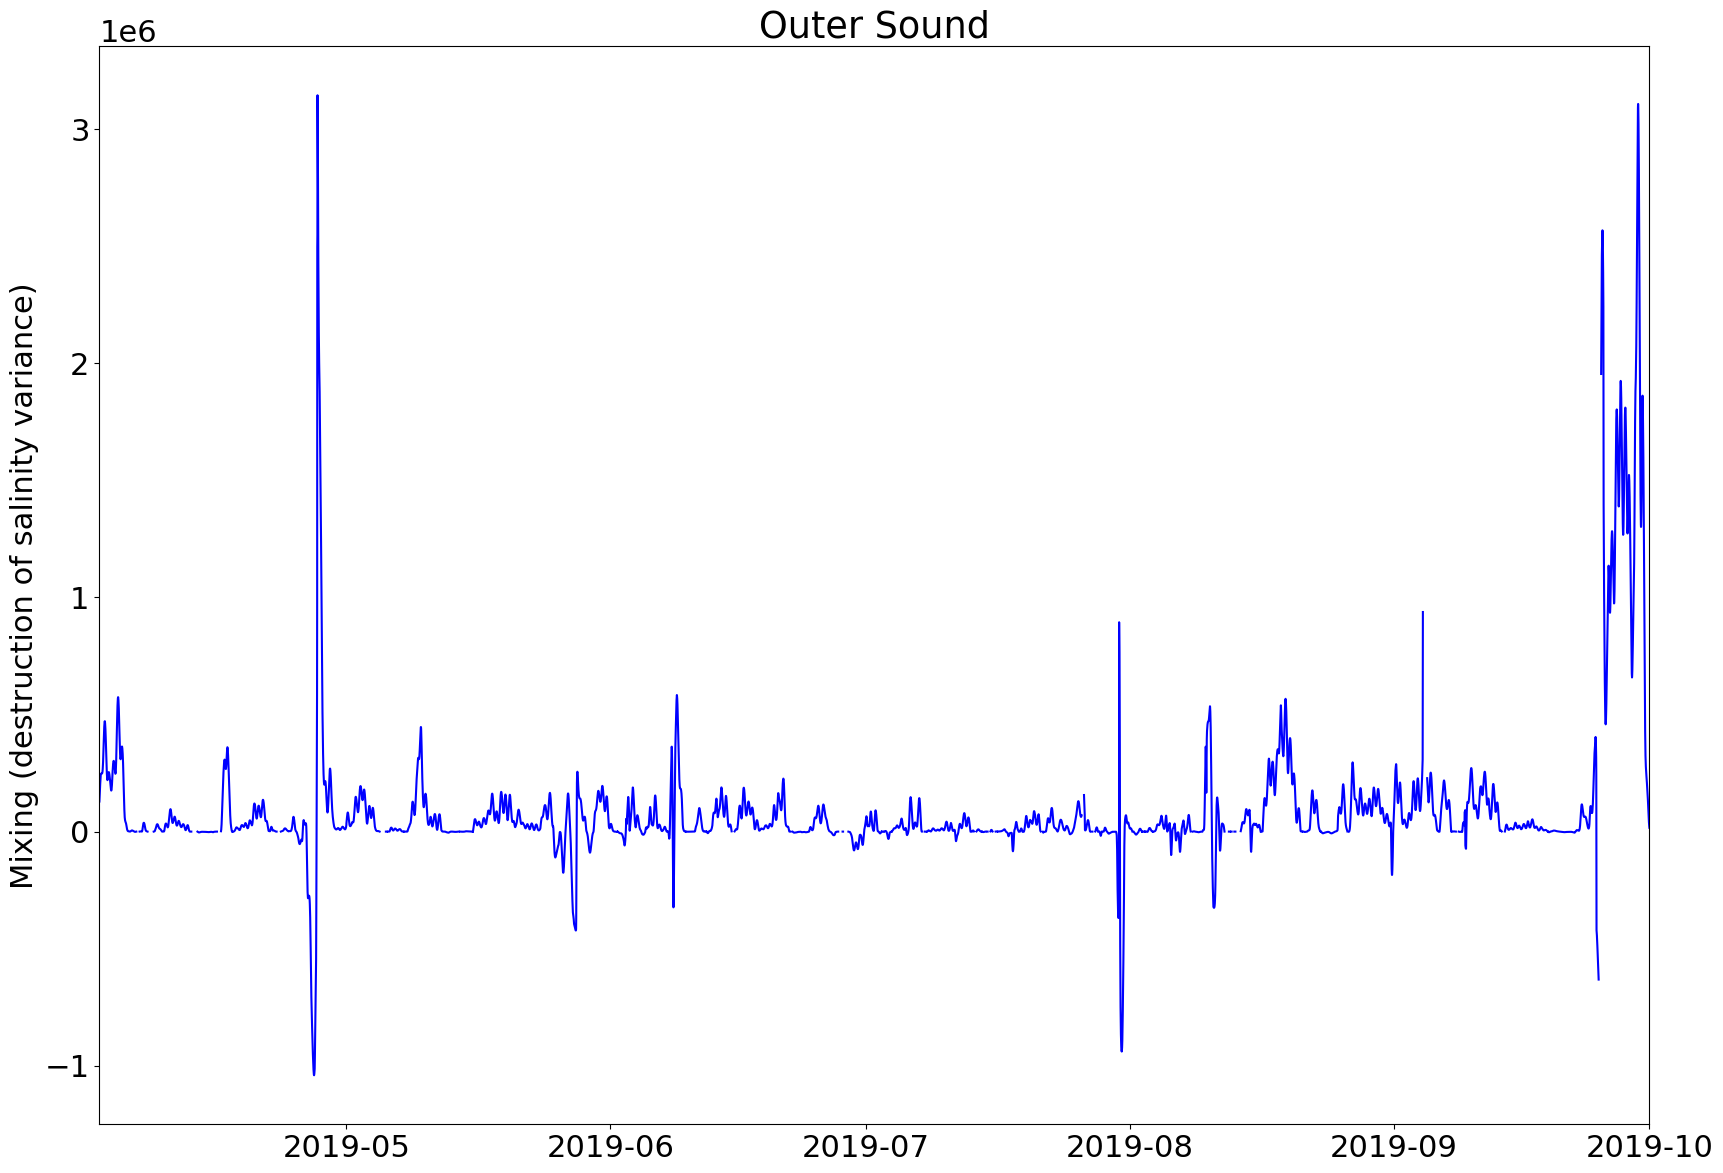

In [13]:
for cross_sect in plot_titles.keys():
    this_nc = nc.Dataset(f'{thredds_source}/{cross_sect}_dqds.nc')
    this_date_str = np.asarray([b''.join(this_str).decode('utf-8') for this_str in this_nc.variables['Times'][:]])
    this_dt = [dt.datetime.strptime(this_str, '%Y-%m-%dT%H:%M:%S.000000') for this_str in this_date_str]
  
    s_in = this_nc['s_in'][:]
    s_out = this_nc['s_out'][:]
    q_in = this_nc['q_in'][:]
    
    M = s_in*(s_in - s_out)*q_in
    plt.figure(figsize=[20,14])
    plt.plot(this_dt, M, c='b')
    plt.xlim([np.min(this_dt), np.max(this_dt)])
    plt.ylabel('Mixing (destruction of salinity variance)')
    plt.title(plot_titles[cross_sect])
